# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [ ]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [ ]:
batch_size = 100
epochs = 5
learning_rate = 1e-3
latent_dim = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print layers, used for debugging
NNprint_ = False
classes = [0,1,2,3,4]
num_classes=len(classes)

### Import MNIST Dataset

In [ ]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

In [ ]:
def get_target_indexes(dset, classes, n_examples):
  """Get indexes for n_examples of class in classes from dataset

  The returned indexes may be used for subsetting a dataset, e.g.
  if we just want classes 0, 1 and 2 and 10 examples of each.
  """
  idxs = []
  ts = []
  n_samples = n_examples * len(classes)

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_examples) and (x.numpy() in classes):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

In [ ]:
# subset training data
idx_train_subset = get_target_indexes(dset_train, classes, 100)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=batch_size)

# subset test data
idx_test_subset = get_target_indexes(dset_test, classes, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=batch_size)

### Plot examples

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
image_channels = example_data.size(1)

def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros = torch.zeros(num_classes,1024)
                samples = torch.cat((torch.rand(latent_dim,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

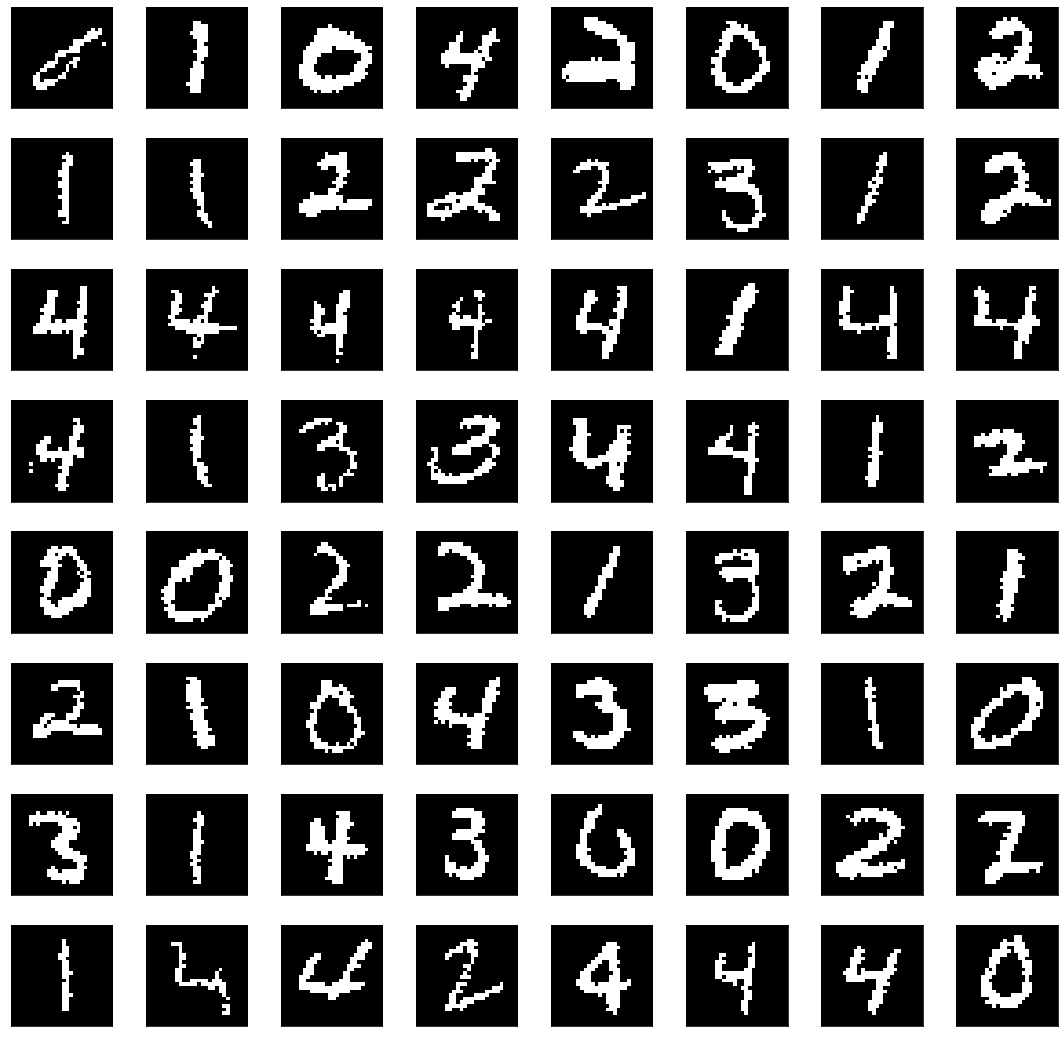

In [ ]:
plot_examples()

### Torch auxiliary modules

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

    
class UnFlatten_FF(torch.nn.Module):
    def forward(self, input, size=784):
        return input.view(-1,1,28,28)
    
    
# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

# Semi-supervised Convolutional CVAE

In [ ]:
class SS_CVAE_CONV(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32, num_labels=0):
        super(SS_CVAE_CONV, self).__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.num_labels=num_labels

        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            NNprint(),
        )

        self.fc1 = torch.nn.Linear(h_dim + num_labels, z_dim)
        self.fc2 = torch.nn.Linear(h_dim + num_labels, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )

        # simple FFNN classifier
        # input: flattened vector, output: probability of each class
        # TODO: implement CNN classifier
        self.classifier = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(784, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.num_labels), # 3 output layer
            torch.nn.Softmax(dim=1)
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() # TODO: Why do it like this?
        eps = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * eps.to(device)
        return z

    def encode(self, x, y):
        # pass x through conv encoder and flatten output to obtain h
        # n.b. normally [x,y] would be encoded, but this is not possible with a
        # CNN architecture
        h = self.encoder(x)

        # concat y (labels) to h, to place in latent space
        h = torch.cat((h, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1)

        # fc1 encodes [h,y] into mu; fc2 encodes [h,y] into logvar
        mu, logvar = self.fc1(h), self.fc2(h) # use relu to prevent negative values
        
        return mu, logvar

    def decode(self, z, y):
        # concat y (labels) to z_lab, to place in latent space
        z_y = torch.cat((z, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1)
        
        # upscale [z,y] to h_dim
        h = self.fc3(z_y)

        # decode upscaled [z,y] to x_recon
        x_recon = self.decoder(h)
        return x_recon
    
    def forward(self, x_labelled, x_unlabelled, y):
        # labeled case ########################################################
        # encode [x_labelled,y] to mu_lab and logvar_lab
        mu_lab, logvar_lab = self.encode(x_labelled, y)
        
        # sample z_lab using mu_lab and logvar_lab
        z_lab = self.reparameterize(mu_lab, logvar_lab)

        # decode [z_lab,y] to get reconstruction
        x_lab_recon = self.decode(z_lab, y)


        # classification ######################################################
        # labelled case - this is used for the classification objective loss
        y_labelled_pred = self.classifier(x_labelled)

        # unlabelled case - predict a y for the entropy term, H(q(y|x))
        y_unlabelled_pred = self.classifier(x_unlabelled)

        # unlabeled case ######################################################
        # integrate over y -- i.e. perform generation and inference for any 
        # possible class of y. Then calculate loss for any case
        # We do this by tiling x_unlabelled and y, then concat for parallelism

        # TODO: repeat copies the data, so there might be a less expensive way to do this
        x_unlab_tiled = x_unlabelled.repeat(self.num_labels,1,1,1)
        # tensor of class labels [0,1,2,3,4,5,6,7,8,9], repeated for number of datapoints as [0_0,0_1,0_n, ...]
        y_unlab_tiled = torch.repeat_interleave(torch.arange(self.num_labels), x_unlabelled.shape[0])

        # encode x_unlab and y_unlab to mu_unlab and logvar_unlab
        mu_unlab, logvar_unlab = self.encode(x_unlab_tiled, y_unlab_tiled)

        # sample z_unlab via mu_unlab and logvar_unlab
        z_unlab = self.reparameterize(mu_unlab, logvar_unlab)

        # decode [z_unlab,y_unlab] to get reconstruction
        x_unlab_recon = self.decode(z_unlab, y_unlab_tiled)

        # TODO: Find better solution
        return {'L' : (mu_lab, logvar_lab, z_lab, x_lab_recon, y_labelled_pred), \
                'U' : (mu_unlab, logvar_unlab, z_unlab, x_unlab_recon, y_unlabelled_pred)}
    
    def log_prob_gaussian(self, x, mu, log_sigma):
      eps = 1e-10 # TODO: handle more elegantly
      sigma = log_sigma.exp()
      logprob = -torch.log(sigma * np.sqrt(2*np.pi) + eps) - 0.5 * ((x - mu)/sigma)**2
      return logprob.view(logprob.size(0), -1).sum(dim=1) # equivalent to reduce_sum

    def L(self, x, x_recon, yp, z, mu, logvar):
      """Calculate -L(x,y)

      -L(x,y) is used to calculate loss for both the Labelled and Unlabelled case

      Formula:
        -L(x,y) = E_q(z|x,y) [ logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y) ]
      """
      # check if x_recon has been repeated for n classes and tile if necessary
      # n.b. this is only needed, because we are tiling, i.e. repeating the tensor
      # for each possible class of y, which enables integrating over y
      if (x.size(0) < x_recon.size(0)):
        factor = int(x_recon.size(0) / x.size(0))
        x = x.repeat(factor,1,1,1) # repeat for each class

      logpx = F.binary_cross_entropy(x_recon, x.to(device), size_average=False, reduction='sum')
      logpy = torch.log(yp)
      logpz = self.log_prob_gaussian(z, torch.zeros_like(z), torch.ones_like(z)) # logprob Gaussian for z, 0, I
      logqz = self.log_prob_gaussian(z, mu, logvar) # logprob Gaussian for z, mu, logvar
      
      return (logpx + logpy + logpz - logqz) # N.B. we don't take the mean here!

    def J_alpha(self, x_labelled, y_labelled, x_unlabelled, Ls, Us, a=.1):
      """Calculate loss as J_alpha

      J_alpha = J + alpha * C

      Where
        J = ∑L(x,y) + ∑U(x)
        -L(x,y) = E_q(z|x,y)[logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y)]
        -U(x) = ∑_y q(y|x)(-L(x,y)) + H(q(y|x))
        C = E_p(x,y) [-logq(y|x)]
      """
      # labelled loss ##########################################################
      mu, logvar = Ls[0], Ls[1]
      z = Ls[2]
      x_recon = Ls[3]

      y_prob = 1/self.num_labels
      Lxy = -1.0 * self.L(x_labelled, x_recon, torch.Tensor([y_prob]), z, mu, logvar)
      Lxy = torch.mean(Lxy) # TODO: Is prob of y *just* 0.1?

      # unlabelled loss ########################################################
      mu, logvar = Us[0], Us[1]
      z = Us[2]
      x_recon = Us[3]
      y_pred = Us[4]
      # use list comprehension to get probabilities for class i for an entire batch
      # i.e. first probs for class == 0, then class == 1, etc.
      y_pred_tiled = torch.cat([y_pred[:,i] for i in range(self.num_labels)])

      y_prob = 1/self.num_labels
      
      U = 0
      # integrate over y
      for i in range(int(x_recon.shape[0]/y_pred.shape[0])):
        l = i*y_pred.shape[0]
        r = l+y_pred.shape[0]
        y_slice = y_pred[:,i] # probabilities for class i for whole batch
        Luxy = -1.0 * self.L(x_unlabelled, x_recon[l:r,:], torch.Tensor([y_prob]), z[l:r], mu[l:r,:], logvar[l:r,:]) # (90,)
        U += (y_slice * Luxy) # TODO: negative or not?
      
      # Luxy = self.L(x_unlabelled, x_recon, torch.Tensor([y_prob]), z, mu, logvar) # 450,8
      # Luxy = -torch.mean(Luxy)
      # y_pred should be (batch,n_classes)
      H = -torch.sum(y_pred * torch.log(y_pred)) # (b,n_classes) * log((b,n_classes))
      # U = -(torch.sum(y_pred_tiled * Luxy) + H)
      U = torch.mean(U) + H

      # classification loss ####################################################
      y = y_labelled
      y_labelled_pred = Ls[4]
      C = F.cross_entropy(y_labelled_pred, y, reduction='sum') / len(y) # reduction 'mean' is deprecated TODO: What does this mean for the output?
      # TODO: check divide by number of samples

      J = Lxy + U 
      Ja = J + a * C
      return Ja

    def sample(self, y):
        """Sample z, conditioning on y and reconstruct
        """
        # sample z ~ N(0,I)
        mu, logvar = torch.zeros((y.size(0),self.z_dim)), torch.ones(y.size(0),self.z_dim)
        z = self.reparameterize(mu, logvar)

        # decode sampled z with condition
        x_recon = self.decode(z, y.to(torch.int64))
        return x_recon

# test model
model = SS_CVAE_CONV(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
# print("Model\n", model)

# test forward-pass
split_by = int(batch_size/10)
x_l = example_data[:split_by]
y_l = example_targets[:split_by]
x_u = example_data[split_by:]
out_fpass = model(x_l, x_u, y_l)

# test loss
loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
print("Loss\n", loss)

Loss
 tensor(-57993.7852, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
model = SS_CVAE_CONV(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        x_u, x_l = train_test_split(images, test_size=0.1, shuffle=True, random_state=42)
        y_u, y_l = train_test_split(labels, test_size=0.1, shuffle=True, random_state=42)
        out_fpass = model(x_l.to(device), x_u.to(device), y_l)
        
        y_pred = out_fpass["L"][4].detach().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        acc = accuracy_score(y_l.numpy(), y_pred)
        loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        running_acc += acc
    
    loss_mean = running_loss/len(train_loader)
    acc_mean = running_acc/len(train_loader)
    return loss_mean, acc_mean
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            x_u, x_l = train_test_split(images, test_size=0.1, shuffle=True, random_state=42)
            y_u, y_l = train_test_split(labels, test_size=0.1, shuffle=True, random_state=42)
            out_fpass = model(x_l.to(device), x_u.to(device), y_l)

            y_pred = out_fpass["L"][4].detach().numpy()
            y_pred = np.argmax(y_pred, axis=1)
            acc = accuracy_score(y_l.numpy(), y_pred)
            loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
            
            running_loss += loss
            running_acc += acc

    loss_mean = running_loss/len(train_loader)
    acc_mean = running_acc/len(train_loader)
    return loss_mean, acc_mean

In [ ]:
epochs = 10

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    print("\t Training ...")
    train_epoch_loss, train_epoch_acc = fit_model(model, dset_train_subset_loader)
    
    print("\t Testing ...")
    test_epoch_loss, test_epoch_acc = test_model(model, dset_test_subset_loader)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")
    print(f"Train Acc: {train_epoch_acc:.4f}")
    print(f"Val Acc: {test_epoch_acc:.4f}")

# torch.save(model.state_dict(), 'cvae.torch')

Epoch 1 of 10
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train Loss: -90124.4531
Val Loss: -18131.5742
Train Acc: 0.1800
Val Acc: 0.0039
Epoch 2 of 10
	 Training ...
	 Testing ...
Train Loss: 402040.9062
Val Loss: -105773.3203
Train Acc: 0.1800
Val Acc: 0.0039
Epoch 3 of 10
	 Training ...
	 Testing ...
Train Loss: -6514411.0000
Val Loss: -109737.4766
Train Acc: 0.1800
Val Acc: 0.0039
Epoch 4 of 10
	 Training ...


KeyboardInterrupt: ignored

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Acc'))

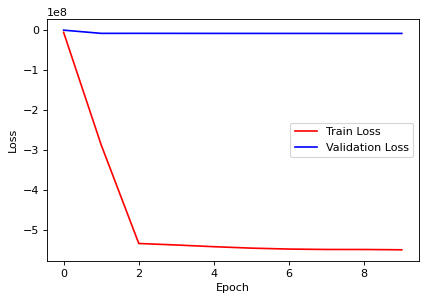

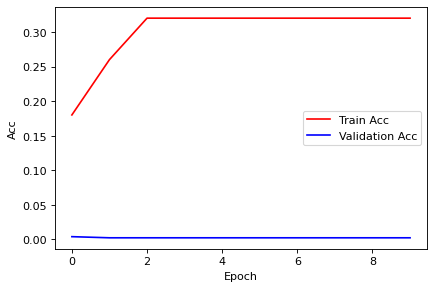

In [ ]:
x_epoch = np.arange(len(train_loss))
plt.figure(dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_epoch, train_loss, 'r', x_epoch, test_loss, 'b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

x_epoch = np.arange(len(train_acc))
plt.figure(dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_epoch, train_acc, 'r', x_epoch, test_acc, 'b')
plt.legend(['Train Acc', 'Validation Acc'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

In [ ]:
plot_examples()

In [ ]:
#Reconstructions
plot_examples(model)

TypeError: ignored

In [ ]:
# Sample latent space
plot_examples(model,sample=True)

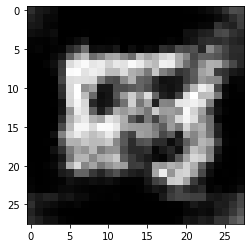

In [ ]:
with torch.no_grad():
  x_recon = model.sample(torch.Tensor([4]))

plt.imshow(x_recon[0][0].cpu(), cmap='gray', interpolation='none')

# Validate model

In [ ]:
accs = []

with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_train_subset_loader):
        y_pred = model.classifier(images)
        acc = accuracy_score(labels.numpy(), np.argmax(y_pred.numpy(), axis=1))
        accs.append(acc)

print("Mean loss (test): ", np.mean(np.array(accs)))

Mean loss (test):  0.366


In [ ]:
accs = []

with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_test_subset_loader):
        y_pred = model.classifier(images)
        acc = accuracy_score(labels.numpy(), np.argmax(y_pred.numpy(), axis=1))
        accs.append(acc)

print("Mean loss (test): ", np.mean(np.array(accs)))

Mean loss (test):  0.422


In [ ]:
print(len(dset_train_subset_loader))

5
